# Capstone Project

## Introduction

Thailand, one of the top 10 countries for tourism, but also one of the most congested countires when it comes to traffic. It was rated as the most congested country in 2016 with drivers spending an average of 64 hours stuck in traffic, of which 33% of that time was spent in traffic during peak hours. Another article, published last year, claimed that the authorities place a lot of trust in the traffic officers to manually handle traffic during peak hours, saying that this was probably the best solution at the time. The article also mentions a solution to automate the traffic more, especially during peak hours, using data that could be collected from the different sections of traffic that occur. This project aims to see if some data can be used to gain insightful knowledge on Bangkok's traffic problem. The dataset will be obtained from the Foursquare API calls which will give venues around the Bangkok area. The goal is to be able to cluster and find patterns the venues in Bangkok and seeing if that relates to any of the congested traffic around that area.


## Data

As mentioned in the introduction, the dataset will be obtained from Foursquare using the functionality to obtain the venues around the Bangkok area. The requests should return several venues in the city that could be used to cluster and plot on a map using the `folium` library of Python. If time allows, we will also look at how time plays a role since Foursquare also has the opening times for the venues, which might be related to peak hours of traffic.

In [7]:
import pandas as pd
import numpy as np
import folium
import requests
from pandas.io.json import json_normalize
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib import colors

In [8]:
# Credentials for BingMaps
BING_KEY = 'DELETED'

In [9]:
# Credentials for Foursquare (NEED TO DELETE AFTER)
CLIENT_ID = 'DELETED' # your Foursquare ID
CLIENT_SECRET = 'DELETED' # your Foursquare Secret
VERSION = 'DELETED' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DELETED
CLIENT_SECRET:DELETED


In [10]:
# Getting latitude and longitude of Bangkok, Thailand.
target_location = '130 Samsen Soi 2, Bangkok, Thailand'

geolocator = Nominatim(user_agent='bangkok_explorer')
location = geolocator.geocode(target_location)
latitude = location.latitude
longitude = location.longitude
print('Coordinates of Bangkok, Thailand: {}, {}.'.format(latitude, longitude))

Coordinates of Bangkok, Thailand: 13.7627862, 100.499614.


In [11]:
# Obtaining Traffic data for Bangkok Area
SouthLatitude = 13.3019
WestLongitude = 100.1208
NorthLatitude = 14.1200
EastLongitude = 100.4739
url = 'http://dev.virtualearth.net/REST/v1/Traffic/Incidents/{},{},{},{}?key={}'.format(
    SouthLatitude,
    WestLongitude,
    NorthLatitude,
    EastLongitude,
    BING_KEY
    )
url

'http://dev.virtualearth.net/REST/v1/Traffic/Incidents/13.3019,100.1208,14.12,100.4739?key=DELETED'

In [12]:
# Getting top 100 venues in Bangkok
LIMIT = 100
radius = 100000
offset=0
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT,
    offset)
url 

'https://api.foursquare.com/v2/venues/explore?&client_id=DELETED&client_secret=DELETED&v=DELETED&ll=13.7627862,100.499614&radius=100000&limit=100&offset=0'

In [7]:
traffic_results = requests.get(url).json()
traffic_results

{'meta': {'code': 200, 'requestId': '5d258982f19f4400252921bd'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4dfb6e666284607895334ba5-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/musicvenue_jazzclub_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1e7931735',
         'name': 'Jazz Club',
         'pluralName': 'Jazz Clubs',
         'primary': True,
         'shortName': 'Jazz Club'}],
       'id': '4dfb6e666284607895334ba5',
       'location': {'address': 'Samsen Rd.',
        'cc': 'TH',
        'city': 'พระนคร',
        'country': 'ประเทศไทย',
        'distance': 88,
        'formattedAddress': ['Samsen Rd.',
         'พระนคร',
         'กรุงเทพมหานคร 10200',
         'ประเทศไทย'],
        'labeledLatLngs': [{'label': 'display'

It seems that the Bing Map Data is sparse for Bangkok, Thailand area for traffic incidents! So we are going to need to find another route.

In [8]:
# Calling the Foursquare API
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d258983dbde1100250c8786'},
 'response': {'groups': [{'items': [{'reasons': {'count': 0,
       'items': [{'reasonName': 'globalInteractionReason',
         'summary': 'This spot is popular',
         'type': 'general'}]},
      'referralId': 'e-0-4dfb6e666284607895334ba5-0',
      'venue': {'categories': [{'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/musicvenue_jazzclub_',
          'suffix': '.png'},
         'id': '4bf58dd8d48988d1e7931735',
         'name': 'Jazz Club',
         'pluralName': 'Jazz Clubs',
         'primary': True,
         'shortName': 'Jazz Club'}],
       'id': '4dfb6e666284607895334ba5',
       'location': {'address': 'Samsen Rd.',
        'cc': 'TH',
        'city': 'พระนคร',
        'country': 'ประเทศไทย',
        'distance': 88,
        'formattedAddress': ['Samsen Rd.',
         'พระนคร',
         'กรุงเทพมหานคร 10200',
         'ประเทศไทย'],
        'labeledLatLngs': [{'label': 'display'

In [9]:
# Grabbing the data.
venues = results['response']['groups'][0]['items']

all_venues = json_normalize(venues)

all_venues.columns

Index(['reasons.count', 'reasons.items', 'referralId', 'venue.categories',
       'venue.id', 'venue.location.address', 'venue.location.cc',
       'venue.location.city', 'venue.location.country',
       'venue.location.crossStreet', 'venue.location.distance',
       'venue.location.formattedAddress', 'venue.location.labeledLatLngs',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.neighborhood', 'venue.location.postalCode',
       'venue.location.state', 'venue.name', 'venue.photos.count',
       'venue.photos.groups', 'venue.venuePage.id'],
      dtype='object')

In [10]:
# Lets look at the raw data.
print(all_venues.shape)
all_venues.head()

(100, 22)


,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,...,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4dfb6e666284607895334ba5-0,"[{'id': '4bf58dd8d48988d1e7931735', 'name': 'J...",4dfb6e666284607895334ba5,Samsen Rd.,TH,พระนคร,ประเทศไทย,NaN,...,"[{'label': 'display', 'lat': 13.76304315030682...",13.763043,100.498839,NaN,10200,กรุงเทพมหานคร,Adhere the 13th Blues Bar,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4fd6b0f0e4b0a25e3aaaa1ff-1,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",4fd6b0f0e4b0a25e3aaaa1ff,23,TH,พระนคร,ประเทศไทย,NaN,...,"[{'label': 'display', 'lat': 13.76230825218113...",13.762308,100.493020,Chana Songkram,10200,กรุงเทพมหานคร,Riva Surya Bangkok,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b0587f9f964a52001aa22e3-2,"[{'id': '52e81612bcbc57f1066b7a3e', 'name': 'B...",4b0587f9f964a52001aa22e3,Na Phra Lan Rd,TH,พระนคร,ประเทศไทย,Maha Rat Rd,...,"[{'label': 'display', 'lat': 13.75173464369186...",13.751735,100.492651,NaN,10200,กรุงเทพมหานคร,Temple of the Emerald Buddha (วัดพระศรีรัตนศาส...,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4e3105c381302aa582e214a7-3,"[{'id': '52e81612bcbc57f1066b7a14', 'name': 'P...",4e3105c381302aa582e214a7,The Grand Palace,TH,พระนคร,ประเทศไทย,NaN,...,"[{'label': 'display', 'lat': 13.750105, 'lng':...",13.750105,100.490524,Phra Borom Maha Ratchawang,10200,กรุงเทพมหานคร,Dusit Maha Prasat Throne Hall (พระที่นั่งดุสิต...,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4b492992f964a520596826e3-4,"[{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...",4b492992f964a520596826e3,151/1 Nakhon Chaisi Rd,TH,ดุสิต,ประเทศไทย,NaN,...,"[{'label': 'display', 'lat': 13.78480512163128...",13.784805,100.512836,NaN,10300,กรุงเทพมหานคร,Look Chin Sri Yan (ลูกชิ้นศรีย่าน),0,[],NaN


In [11]:
# Grabbing all the data we can
for offset in range(1, 20):
    LIMIT = 100
    radius = 100000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&offset={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT,
        offset)
    all_venues = pd.concat([all_venues, json_normalize(requests.get(url).json()['response']['groups'][0]['items'])], ignore_index=True)

all_venues.shape

(2000, 22)

In [12]:
# Looking for interesting columns that we should keep.
for c in all_venues.columns:
    try:
        print(c)
        print(all_venues[c].unique())
    except:
        continue

reasons.count
[0]
reasons.items
referralId
['e-0-4dfb6e666284607895334ba5-0' 'e-0-4fd6b0f0e4b0a25e3aaaa1ff-1'
 'e-0-4b0587f9f964a52001aa22e3-2' 'e-0-4e3105c381302aa582e214a7-3'
 'e-0-4b492992f964a520596826e3-4' 'e-0-4da03dcfa77d816ea6b81309-5'
 'e-0-4c80b79374d7b60cabdc6fd8-6' 'e-0-55461e9b498e777ecbdb0696-7'
 'e-0-50568fd6e4b02204c3b9dd0b-8' 'e-0-54e2cdc7498eefaf2e840b85-9'
 'e-0-4b377134f964a520154125e3-10' 'e-0-509a31b8e4b07ae84f975465-11'
 'e-0-4c16c642955976b0e31ba5f6-12' 'e-0-500532c6e4b0f0192ae31b47-13'
 'e-0-4bfde0aef7c82d7fa0e98e04-14' 'e-0-54a15cd5498e598692a22594-15'
 'e-0-4dfb0210d164f73de7cbbcd3-16' 'e-0-5131c9a5e4b09cc35d6934f3-17'
 'e-0-532c0ca5498e9f9699c35813-18' 'e-0-592fd22df5e9d71a33527d14-19'
 'e-0-4bee67afd355a5933cdb0a60-20' 'e-0-4d7f5c0a4219a1cdedaa72d3-21'
 'e-0-4b41cdfbf964a52009c925e3-22' 'e-0-51a257a5498e7f0ebdea7108-23'
 'e-0-58edbb2214f8f4278e385b8f-24' 'e-0-4baaeda4f964a520428e3ae3-25'
 'e-0-54a8c73f498e9be466164ab5-26' 'e-0-4c2adbf3ae6820a1e9011743-27'
 

In [13]:
# Grabbing interesting columns
filtered_columns = ['venue.categories', 'venue.location.city', 'venue.location.lat', 'venue.location.lng', 'venue.name']
df = all_venues.loc[:, filtered_columns]
df.head()

,venue.categories,venue.location.city,venue.location.lat,venue.location.lng,venue.name
0,"[{'id': '4bf58dd8d48988d1e7931735', 'name': 'J...",พระนคร,13.763043,100.498839,Adhere the 13th Blues Bar
1,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",พระนคร,13.762308,100.493020,Riva Surya Bangkok
2,"[{'id': '52e81612bcbc57f1066b7a3e', 'name': 'B...",พระนคร,13.751735,100.492651,Temple of the Emerald Buddha (วัดพระศรีรัตนศาส...
3,"[{'id': '52e81612bcbc57f1066b7a14', 'name': 'P...",พระนคร,13.750105,100.490524,Dusit Maha Prasat Throne Hall (พระที่นั่งดุสิต...
4,"[{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...",ดุสิต,13.784805,100.512836,Look Chin Sri Yan (ลูกชิ้นศรีย่าน)


In [14]:
# Lets look at the amount of missing data in each column.
print(df.shape)
df.isna().sum()

(2000, 5)


venue.categories       0
venue.location.city    0
venue.location.lat     0
venue.location.lng     0
venue.name             0
dtype: int64

In [15]:
# Looking at uniqueness of each column.
for i in df.columns:
    try:
        print(i)
        print(df[i].unique())
    except:
        continue

venue.categories
venue.location.city
['พระนคร' 'ดุสิต' 'Chana Songkhram' 'ป้อมปราบศัตรูพ่าย' 'บางกอกน้อย'
 'ปทุมวัน' 'พญาไท' 'บางกอกใหญ่' 'บางพลัด' 'ราชเทวี' 'คลองสาน' 'บางรัก'
 'บางคอแหลม' 'วัฒนา' 'ธนบุรี' 'จตุจักร' 'สาทร' 'สัมพันธวงศ์' 'คลองเตย'
 'ภาษีเจริญ' 'บางใหญ่' 'เขตคลองเตย' 'Din Daeng' 'ยานนาวา' 'ห้วยขวาง'
 'Yannawa' 'เมืองนนทบุรี' 'ทวีวัฒนา' 'บางซื่อ' 'ลาดพร้าว' 'บางแค'
 'วังทองหลาง' 'บางขุนเทียน']
venue.location.lat
[13.76304315 13.76230825 13.75173464 13.750105   13.78480512 13.76236268
 13.74457758 13.74093665 13.75978852 13.72054164 13.7458388  13.77226575
 13.7239926  13.78187876 13.73967639 13.77956334 13.746596   13.73055253
 13.743696   13.74416201 13.7595218  13.7793751  13.74635415 13.75593072
 13.74650859 13.76841854 13.77626144 13.734807   13.75146354 13.74826017
 13.75177218 13.74697923 13.74422676 13.7241436  13.74664581 13.74587903
 13.74676056 13.7341441  13.72302222 13.72202903 13.74715965 13.79066562
 13.71774137 13.73098493 13.72625294 13.70914072 13.746143

In [16]:
# Exploring the categories for feature extraction.
for i in df['venue.categories']:
    print(i)

[{'id': '4bf58dd8d48988d1e7931735', 'name': 'Jazz Club', 'pluralName': 'Jazz Clubs', 'shortName': 'Jazz Club', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/arts_entertainment/musicvenue_jazzclub_', 'suffix': '.png'}, 'primary': True}]
[{'id': '4bf58dd8d48988d1fa931735', 'name': 'Hotel', 'pluralName': 'Hotels', 'shortName': 'Hotel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_', 'suffix': '.png'}, 'primary': True}]
[{'id': '52e81612bcbc57f1066b7a3e', 'name': 'Buddhist Temple', 'pluralName': 'Buddhist Temples', 'shortName': 'Buddhist Temple', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/religious_', 'suffix': '.png'}, 'primary': True}]
[{'id': '52e81612bcbc57f1066b7a14', 'name': 'Palace', 'pluralName': 'Palaces', 'shortName': 'Palace', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/default_', 'suffix': '.png'}, 'primary': True}]
[{'id': '4bf58dd8d48988d1d1941735', 'name': 'Noodle House', 'pluralNa

[{'id': '4bf58dd8d48988d1d0941735', 'name': 'Dessert Shop', 'pluralName': 'Dessert Shops', 'shortName': 'Desserts', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/dessert_', 'suffix': '.png'}, 'primary': True}]
[{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_', 'suffix': '.png'}, 'primary': True}]
[{'id': '4bf58dd8d48988d1fa931735', 'name': 'Hotel', 'pluralName': 'Hotels', 'shortName': 'Hotel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_', 'suffix': '.png'}, 'primary': True}]
[{'id': '4bf58dd8d48988d1fa931735', 'name': 'Hotel', 'pluralName': 'Hotels', 'shortName': 'Hotel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_', 'suffix': '.png'}, 'primary': True}]
[{'id': '4bf58dd8d48988d114951735', 'name': 'Bookstore', 'pluralName': 'Bookstores', 'shortName': 'Bookstore', 'icon': {'pr

[{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_', 'suffix': '.png'}, 'primary': True}]
[{'id': '4bf58dd8d48988d10f941735', 'name': 'Indian Restaurant', 'pluralName': 'Indian Restaurants', 'shortName': 'Indian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/indian_', 'suffix': '.png'}, 'primary': True}]
[{'id': '4bf58dd8d48988d163941735', 'name': 'Park', 'pluralName': 'Parks', 'shortName': 'Park', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/park_', 'suffix': '.png'}, 'primary': True}]
[{'id': '4bf58dd8d48988d1fa931735', 'name': 'Hotel', 'pluralName': 'Hotels', 'shortName': 'Hotel', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/travel/hotel_', 'suffix': '.png'}, 'primary': True}]
[{'id': '4bf58dd8d48988d1d1941735', 'name': 'Noodle House', 'pluralName': 'Noodle Houses', 'shortName': 'Noodles

In [17]:
df['Category'] = df.apply(lambda row: row['venue.categories'][0]['name'], axis=1)
print(df.head())
df.Category.unique()

                                    venue.categories venue.location.city  \
0  [{'id': '4bf58dd8d48988d1e7931735', 'name': 'J...              พระนคร   
1  [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...              พระนคร   
2  [{'id': '52e81612bcbc57f1066b7a3e', 'name': 'B...              พระนคร   
3  [{'id': '52e81612bcbc57f1066b7a14', 'name': 'P...              พระนคร   
4  [{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...               ดุสิต   

   venue.location.lat  venue.location.lng  \
0           13.763043          100.498839   
1           13.762308          100.493020   
2           13.751735          100.492651   
3           13.750105          100.490524   
4           13.784805          100.512836   

                                          venue.name         Category  
0                          Adhere the 13th Blues Bar        Jazz Club  
1                                 Riva Surya Bangkok            Hotel  
2  Temple of the Emerald Buddha (วัดพระศรีรัตนศาส...  Bu

array(['Jazz Club', 'Hotel', 'Buddhist Temple', 'Palace', 'Noodle House',
       'Massage Studio', 'Shrine', 'Coffee Shop', 'Factory', 'Bookstore',
       'Park', 'Resort', 'Gym / Fitness Center', 'Japanese Restaurant',
       'Tour Provider', 'Historic Site', 'Thai Restaurant', 'Spa',
       'Som Tum Restaurant', 'Supermarket', 'Hostel', 'Bakery',
       'Ice Cream Shop', 'Shopping Mall', 'Dessert Shop', 'Hotel Bar',
       'Multiplex', 'Indian Restaurant', 'Bar', 'Tonkatsu Restaurant',
       'Restaurant', 'Vegetarian / Vegan Restaurant', 'Asian Restaurant',
       'Café', 'Cocktail Bar', 'Breakfast Spot', 'Library', 'Flea Market',
       'Art Gallery', 'Residential Building (Apartment / Condo)',
       'BBQ Joint', 'Surf Spot', 'Miscellaneous Shop', 'Night Market',
       'Sushi Restaurant', 'German Restaurant', 'Seafood Restaurant',
       'Shabu-Shabu Restaurant', 'Chinese Restaurant',
       'Vietnamese Restaurant', 'Italian Restaurant'], dtype=object)

In [18]:
# Replace categories with something more similiar to each other.
def replace_category(df):
    print(df)
    cat = df['Category']
    if 'Restaurant' in cat or 'Joint' in cat or 'House' in cat or 'Place' in cat or 'Bar' in cat or 'Café' in cat or 'Pub' in cat:
        df.Category = 'Food'
    elif 'Hotel' in cat or 'Spa' in cat or 'Massage' in cat or 'Hostel' in cat:
        df.Category = 'Service'
    else:
        df.Category ='Attraction'
    return df

print(df)
df_new = df.apply(replace_category, axis=1)
df_new

                                       venue.categories venue.location.city  \
0     [{'id': '4bf58dd8d48988d1e7931735', 'name': 'J...              พระนคร   
1     [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...              พระนคร   
2     [{'id': '52e81612bcbc57f1066b7a3e', 'name': 'B...              พระนคร   
3     [{'id': '52e81612bcbc57f1066b7a14', 'name': 'P...              พระนคร   
4     [{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...               ดุสิต   
5     [{'id': '52f2ab2ebcbc57f1066b8b3c', 'name': 'M...     Chana Songkhram   
6     [{'id': '4eb1d80a4b900d56c88a45ff', 'name': 'S...   ป้อมปราบศัตรูพ่าย   
7     [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...              พระนคร   
8     [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...          บางกอกน้อย   
9     [{'id': '4eb1bea83b7b6f98df247e06', 'name': 'F...              พระนคร   
10    [{'id': '4bf58dd8d48988d114951735', 'name': 'B...             ปทุมวัน   
11    [{'id': '4bf58dd8d48988d163941735', 'name': 'P

Name: 23, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d111941735', 'name': 'J...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7465
venue.location.lng                                               100.532
venue.name                                   Tonkatsu Wako (หมูทอด วาโก)
Category                                             Japanese Restaurant
Name: 24, dtype: object
venue.categories       [{'id': '4deefb944765f83613cdba6e', 'name': 'H...
venue.location.city                                              ราชเทวี
venue.location.lat                                               13.7684
venue.location.lng                                               100.533
venue.name                             Phya Thai Palace (พระราชวังพญาไท)
Category                                                   Historic Site
Name: 25, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1ee93

Name: 84, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1ff941735', 'name': 'M...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7312
venue.location.lng                                               100.569
venue.name                                                 Another Story
Category                                              Miscellaneous Shop
Name: 85, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d111941735', 'name': 'J...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7325
venue.location.lng                                               100.567
venue.name                             Kenshin Izakaya (เคนชิน อิซากายะ)
Category                                             Japanese Restaurant
Name: 86, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d10f94

Name: 131, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1d5941735', 'name': 'H...
venue.location.city                                               พระนคร
venue.location.lat                                               13.7241
venue.location.lng                                               100.514
venue.name                                                The Bamboo Bar
Category                                                       Hotel Bar
Name: 132, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7466
venue.location.lng                                               100.539
venue.name                                 centralwOrld (เซ็นทรัลเวิลด์)
Category                                                   Shopping Mall
Name: 133, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d18

Name: 168, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1f7941735', 'name': 'F...
venue.location.city                                              จตุจักร
venue.location.lat                                                  13.8
venue.location.lng                                               100.551
venue.name                     Chatuchak Weekend Market (ตลาดนัดจตุจักร)
Category                                                     Flea Market
Name: 169, dtype: object
venue.categories       [{'id': '56aa371be4b08b9a8d573502', 'name': 'S...
venue.location.city                                               บางรัก
venue.location.lat                                               13.7206
venue.location.lng                                               100.521
venue.name                                       Baan Somtum (บ้านส้มตำ)
Category                                              Som Tum Restaurant
Name: 170, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1e

Name: 234, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d149941735', 'name': 'T...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7341
venue.location.lng                                               100.528
venue.name                                                  สุกี้สามย่าน
Category                                                 Thai Restaurant
Name: 235, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...
venue.location.city                                              คลองสาน
venue.location.lat                                                13.723
venue.location.lng                                               100.511
venue.name                                         The Peninsula Bangkok
Category                                                           Hotel
Name: 236, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1f

Name: 284, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d10f941735', 'name': 'I...
venue.location.city                                           เขตคลองเตย
venue.location.lat                                               13.7456
venue.location.lng                                               100.556
venue.name                             Charcoal Tandoor Grill & Mixology
Category                                               Indian Restaurant
Name: 285, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...
venue.location.city                                              คลองเตย
venue.location.lat                                               13.7314
venue.location.lng                                                100.57
venue.name                                    EmQuartier (เอ็มควอเทียร์)
Category                                                   Shopping Mall
Name: 286, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d11

Name: 305, dtype: object
venue.categories       [{'id': '4eb1bea83b7b6f98df247e06', 'name': 'F...
venue.location.city                                               พระนคร
venue.location.lat                                               13.7205
venue.location.lng                                                 100.5
venue.name                                                        ELF925
Category                                                         Factory
Name: 306, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d114951735', 'name': 'B...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7458
venue.location.lng                                               100.535
venue.name                                Books Kinokuniya (คิโนะคูนิยะ)
Category                                                       Bookstore
Name: 307, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d16

Name: 374, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1df931735', 'name': 'B...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7292
venue.location.lng                                               100.581
venue.name                                       Ginzado (Ginzado (銀座堂))
Category                                                       BBQ Joint
Name: 375, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...
venue.location.city                                              คลองเตย
venue.location.lat                                               13.7166
venue.location.lng                                               100.561
venue.name                                  Heng Chun Seng (เฮ้งชุนเส็ง)
Category                                                    Noodle House
Name: 376, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d14

Name: 428, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1d5941735', 'name': 'H...
venue.location.city                                               พระนคร
venue.location.lat                                               13.7241
venue.location.lng                                               100.514
venue.name                                                The Bamboo Bar
Category                                                       Hotel Bar
Name: 429, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7466
venue.location.lng                                               100.539
venue.name                                 centralwOrld (เซ็นทรัลเวิลด์)
Category                                                   Shopping Mall
Name: 430, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d18

Name: 458, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d11e941735', 'name': 'C...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7456
venue.location.lng                                               100.556
venue.name                                                 Havana Social
Category                                                    Cocktail Bar
Name: 459, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d143941735', 'name': 'B...
venue.location.city                                          สัมพันธวงศ์
venue.location.lat                                               13.7373
venue.location.lng                                               100.514
venue.name                                   โจ๊กตลาดน้อย (เจ๊หมวยเกี้ย)
Category                                                  Breakfast Spot
Name: 460, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1f

Name: 541, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d116941735', 'name': 'B...
venue.location.city                                               บางรัก
venue.location.lat                                               13.7224
venue.location.lng                                               100.514
venue.name                                                    Jack's Bar
Category                                                             Bar
Name: 542, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7406
venue.location.lng                                               100.542
venue.name                                                Hansar Bangkok
Category                                                           Hotel
Name: 543, dtype: object
venue.categories       [{'id': '55a59af1e4b013909

Name: 600, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...
venue.location.city                                               พระนคร
venue.location.lat                                               13.7409
venue.location.lng                                               100.495
venue.name                                        Starbucks (สตาร์บัคส์)
Category                                                     Coffee Shop
Name: 601, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...
venue.location.city                                           บางกอกน้อย
venue.location.lat                                               13.7598
venue.location.lng                                               100.486
venue.name                                        Starbucks (สตาร์บัคส์)
Category                                                     Coffee Shop
Name: 602, dtype: object
venue.categories       [{'id': '4eb1bea83b7b6f98d

Name: 632, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...
venue.location.city                                               พระนคร
venue.location.lat                                                13.722
venue.location.lng                                               100.529
venue.name                                                     W Bangkok
Category                                                           Hotel
Name: 633, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d114951735', 'name': 'B...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7472
venue.location.lng                                                100.54
venue.name                                Books Kinokuniya (คิโนะคูนิยะ)
Category                                                       Bookstore
Name: 634, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d14

Name: 714, dtype: object
venue.categories       [{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7464
venue.location.lng                                               100.535
venue.name                            Gourmet Market (กูร์เมต์ มาร์เก็ต)
Category                                                     Supermarket
Name: 715, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1ee931735', 'name': 'H...
venue.location.city                                               พระนคร
venue.location.lat                                               13.7559
venue.location.lng                                               100.534
venue.name                                               In a Box Hostel
Category                                                          Hostel
Name: 716, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d11

Name: 787, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7408
venue.location.lng                                               100.568
venue.name                                                 The Oasis Spa
Category                                                             Spa
Name: 788, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...
venue.location.city                                              ยานนาวา
venue.location.lat                                                13.678
venue.location.lng                                               100.528
venue.name                                ก๋วยเตี๋ยวเนื้อตุ๋นท่าน้ำสาธุฯ
Category                                                    Noodle House
Name: 789, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d10

Name: 872, dtype: object
venue.categories       [{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7323
venue.location.lng                                               100.569
venue.name                            Gourmet Market (กูร์เมต์ มาร์เก็ต)
Category                                                     Supermarket
Name: 873, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...
venue.location.city                                              คลองเตย
venue.location.lat                                               13.7171
venue.location.lng                                               100.571
venue.name                                        Starbucks (สตาร์บัคส์)
Category                                                     Coffee Shop
Name: 874, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1e

Name: 944, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7355
venue.location.lng                                               100.546
venue.name                                        Starbucks (สตาร์บัคส์)
Category                                                     Coffee Shop
Name: 945, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...
venue.location.city                                               บางรัก
venue.location.lat                                               13.7191
venue.location.lng                                               100.522
venue.name                                    Eastin Grand Hotel Sathorn
Category                                                           Hotel
Name: 946, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1f

Name: 974, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1e3941735', 'name': 'S...
venue.location.city                                              คลองเตย
venue.location.lat                                               13.7205
venue.location.lng                                               100.567
venue.name                                      Flow House (โฟลว์ เฮาส์)
Category                                                       Surf Spot
Name: 975, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1ff941735', 'name': 'M...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7312
venue.location.lng                                               100.569
venue.name                                                 Another Story
Category                                              Miscellaneous Shop
Name: 976, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d11

Name: 1065, dtype: object
venue.categories       [{'id': '4d954b06a243a5684965b473', 'name': 'R...
venue.location.city                                                 สาทร
venue.location.lat                                               13.7228
venue.location.lng                                               100.534
venue.name                                           The Met (เดอะ เม็ท)
Category                        Residential Building (Apartment / Condo)
Name: 1066, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...
venue.location.city                                              คลองเตย
venue.location.lat                                               13.7198
venue.location.lng                                               100.567
venue.name                                          Yunomori (ยูโนะโมริ)
Category                                                             Spa
Name: 1067, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1136, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7406
venue.location.lng                                               100.542
venue.name                                                Hansar Bangkok
Category                                                           Hotel
Name: 1137, dtype: object
venue.categories       [{'id': '55a59af1e4b013909087cb03', 'name': 'T...
venue.location.city                                               บางรัก
venue.location.lat                                                13.729
venue.location.lng                                                100.53
venue.name                                         Katsu-Shin (คัสซึชิน)
Category                                             Tonkatsu Restaurant
Name: 1138, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1167, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...
venue.location.city                                              คลองเตย
venue.location.lat                                               13.7166
venue.location.lng                                               100.561
venue.name                                  Heng Chun Seng (เฮ้งชุนเส็ง)
Category                                                    Noodle House
Name: 1168, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d149941735', 'name': 'T...
venue.location.city                                            ภาษีเจริญ
venue.location.lat                                               13.7171
venue.location.lng                                               100.446
venue.name                                Kha Moo Bang Wa (ขาหมูบางหว้า)
Category                                                 Thai Restaurant
Name: 1169, dtype: object
venue.categories       [{'id': '52f2ab2ebcbc57

Name: 1245, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1d3941735', 'name': 'V...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7479
venue.location.lng                                               100.552
venue.name                                                      Na Aroon
Category                                   Vegetarian / Vegan Restaurant
Name: 1246, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d142941735', 'name': 'A...
venue.location.city                                               ธนบุรี
venue.location.lat                                               13.7035
venue.location.lng                                               100.485
venue.name                                      Koa Chun Huad (กอชุนฮวด)
Category                                                Asian Restaurant
Name: 1247, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1293, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...
venue.location.city                                                วัฒนา
venue.location.lat                                                 13.74
venue.location.lng                                                100.59
venue.name                                          Kaizen Coffee Newold
Category                                                     Coffee Shop
Name: 1294, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7351
venue.location.lng                                               100.582
venue.name                                   The Commons (เดอะคอมม่อนส์)
Category                                                   Shopping Mall
Name: 1295, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1324, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...
venue.location.city                                              คลองสาน
venue.location.lat                                                13.723
venue.location.lng                                               100.511
venue.name                                         The Peninsula Bangkok
Category                                                           Hotel
Name: 1325, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...
venue.location.city                                               พระนคร
venue.location.lat                                                13.722
venue.location.lng                                               100.529
venue.name                                                     W Bangkok
Category                                                           Hotel
Name: 1326, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1404, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d149941735', 'name': 'T...
venue.location.city                                               พระนคร
venue.location.lat                                               13.7442
venue.location.lng                                               100.492
venue.name             Supanniga Eating Room x Roots Coffee (ห้องทานข...
Category                                                 Thai Restaurant
Name: 1405, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...
venue.location.city                                               พระนคร
venue.location.lat                                               13.7595
venue.location.lng                                               100.499
venue.name                               Pai Spa (ปัยย์สปา บ้านรามบุตรี)
Category                                                             Spa
Name: 1406, dtype: object
venue.categories       [{'id': '56aa371be4b08b

Name: 1465, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d149941735', 'name': 'T...
venue.location.city                                            ภาษีเจริญ
venue.location.lat                                               13.7171
venue.location.lng                                               100.446
venue.name                                Kha Moo Bang Wa (ขาหมูบางหว้า)
Category                                                 Thai Restaurant
Name: 1466, dtype: object
venue.categories       [{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'S...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7323
venue.location.lng                                               100.569
venue.name                            Gourmet Market (กูร์เมต์ มาร์เก็ต)
Category                                                     Supermarket
Name: 1467, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1492, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7351
venue.location.lng                                               100.582
venue.name                                   The Commons (เดอะคอมม่อนส์)
Category                                                   Shopping Mall
Name: 1493, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7344
venue.location.lng                                               100.588
venue.name                                             ก๋วยเตี๋ยวนายแว่น
Category                                                    Noodle House
Name: 1494, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1562, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1df931735', 'name': 'B...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7292
venue.location.lng                                               100.581
venue.name                                       Ginzado (Ginzado (銀座堂))
Category                                                       BBQ Joint
Name: 1563, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...
venue.location.city                                              คลองเตย
venue.location.lat                                               13.7166
venue.location.lng                                               100.561
venue.name                                  Heng Chun Seng (เฮ้งชุนเส็ง)
Category                                                    Noodle House
Name: 1564, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1631, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7406
venue.location.lng                                               100.542
venue.name                                                Hansar Bangkok
Category                                                           Hotel
Name: 1632, dtype: object
venue.categories       [{'id': '55a59af1e4b013909087cb03', 'name': 'T...
venue.location.city                                               บางรัก
venue.location.lat                                                13.729
venue.location.lng                                                100.53
venue.name                                         Katsu-Shin (คัสซึชิน)
Category                                             Tonkatsu Restaurant
Name: 1633, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1660, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1ed941735', 'name': 'S...
venue.location.city                                              คลองเตย
venue.location.lat                                               13.7198
venue.location.lng                                               100.567
venue.name                                          Yunomori (ยูโนะโมริ)
Category                                                             Spa
Name: 1661, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1df931735', 'name': 'B...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7292
venue.location.lng                                               100.581
venue.name                                       Ginzado (Ginzado (銀座堂))
Category                                                       BBQ Joint
Name: 1662, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1727, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...
venue.location.city                                            บางคอแหลม
venue.location.lat                                               13.7091
venue.location.lng                                               100.514
venue.name                           Kuayjup Mr. Jo (ก๋วยจั๊บมิสเตอร์โจ)
Category                                                    Noodle House
Name: 1728, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...
venue.location.city                                              ปทุมวัน
venue.location.lat                                               13.7461
venue.location.lng                                               100.533
venue.name                                   Siam Center (สยามเซ็นเตอร์)
Category                                                   Shopping Mall
Name: 1729, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

venue.categories       [{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...
venue.location.city                                                วัฒนา
venue.location.lat                                                 13.74
venue.location.lng                                                100.59
venue.name                                          Kaizen Coffee Newold
Category                                                     Coffee Shop
Name: 1789, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1fd941735', 'name': 'S...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7351
venue.location.lng                                               100.582
venue.name                                   The Commons (เดอะคอมม่อนส์)
Category                                                   Shopping Mall
Name: 1790, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...

Name: 1806, dtype: object
venue.categories       [{'id': '4deefb944765f83613cdba6e', 'name': 'H...
venue.location.city                                              ราชเทวี
venue.location.lat                                               13.7684
venue.location.lng                                               100.533
venue.name                             Phya Thai Palace (พระราชวังพญาไท)
Category                                                   Historic Site
Name: 1807, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1ee931735', 'name': 'H...
venue.location.city                                                พญาไท
venue.location.lat                                               13.7763
venue.location.lng                                               100.542
venue.name                                    The Yard (บ้านญาติ โฮสเทล)
Category                                                          Hostel
Name: 1808, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1880, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d111941735', 'name': 'J...
venue.location.city                                                วัฒนา
venue.location.lat                                               13.7229
venue.location.lng                                               100.583
venue.name                                             Teppen (เท้ปเป้น)
Category                                             Japanese Restaurant
Name: 1881, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1ce941735', 'name': 'S...
venue.location.city                                              Yannawa
venue.location.lat                                               13.7016
venue.location.lng                                               100.537
venue.name                                                The Oyster Bar
Category                                              Seafood Restaurant
Name: 1882, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

Name: 1950, dtype: object
venue.categories       [{'id': '4bf58dd8d48988d1f7941735', 'name': 'F...
venue.location.city                                              จตุจักร
venue.location.lat                                                  13.8
venue.location.lng                                               100.551
venue.name                     Chatuchak Weekend Market (ตลาดนัดจตุจักร)
Category                                                     Flea Market
Name: 1951, dtype: object
venue.categories       [{'id': '56aa371be4b08b9a8d573502', 'name': 'S...
venue.location.city                                               บางรัก
venue.location.lat                                               13.7206
venue.location.lng                                               100.521
venue.name                                       Baan Somtum (บ้านส้มตำ)
Category                                              Som Tum Restaurant
Name: 1952, dtype: object
venue.categories       [{'id': '4bf58dd8d48988

,venue.categories,venue.location.city,venue.location.lat,venue.location.lng,venue.name,Category
0,"[{'id': '4bf58dd8d48988d1e7931735', 'name': 'J...",พระนคร,13.763043,100.498839,Adhere the 13th Blues Bar,Attraction
1,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",พระนคร,13.762308,100.493020,Riva Surya Bangkok,Service
2,"[{'id': '52e81612bcbc57f1066b7a3e', 'name': 'B...",พระนคร,13.751735,100.492651,Temple of the Emerald Buddha (วัดพระศรีรัตนศาส...,Attraction
3,"[{'id': '52e81612bcbc57f1066b7a14', 'name': 'P...",พระนคร,13.750105,100.490524,Dusit Maha Prasat Throne Hall (พระที่นั่งดุสิต...,Attraction
4,"[{'id': '4bf58dd8d48988d1d1941735', 'name': 'N...",ดุสิต,13.784805,100.512836,Look Chin Sri Yan (ลูกชิ้นศรีย่าน),Food
5,"[{'id': '52f2ab2ebcbc57f1066b8b3c', 'name': 'M...",Chana Songkhram,13.762363,100.495126,Massage In Garden,Service
6,"[{'id': '4eb1d80a4b900d56c88a45ff', 'name': 'S...",ป้อมปราบศัตรูพ่าย,13.744578,100.510755,Tai Hong Kong Shrine (ศาลเจ้าไต้ฮงกง),Attraction
7,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",พระนคร,13.740937,100.495394,Starbucks (สตาร์บัคส์),Attraction
8,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",บางกอกน้อย,13.759789,100.486097,Starbucks (สตาร์บัคส์),Attraction
9,"[{'id': '4eb1bea83b7b6f98df247e06', 'name': 'F...",พระนคร,13.720542,100.499507,ELF925,Attraction


In [19]:
# Lets create numeric categories for the city.
data = pd.concat([df_new, pd.get_dummies(df_new['Category'])], axis=1)
data.shape

(2000, 9)

In [20]:
# Grabbing features we want and renaming for convenience.
data.columns = ['venue.categories', 'venue.location.city', 'Latitude', 'Longitude', 'Venue_Name', 'Category', 'Attraction', 'Food', 'Service']
data_columns = data.columns
print(data_columns)
df_final = data[data_columns[2:]].set_index('Venue_Name')
df_final.head()

Index(['venue.categories', 'venue.location.city', 'Latitude', 'Longitude',
       'Venue_Name', 'Category', 'Attraction', 'Food', 'Service'],
      dtype='object')


,Latitude,Longitude,Category,Attraction,Food,Service
Venue_Name,,,,,,
Adhere the 13th Blues Bar,13.763043,100.498839,Attraction,1,0,0
Riva Surya Bangkok,13.762308,100.493020,Service,0,0,1
Temple of the Emerald Buddha (วัดพระศรีรัตนศาสดาราม (วัดพระแก้ว)),13.751735,100.492651,Attraction,1,0,0
Dusit Maha Prasat Throne Hall (พระที่นั่งดุสิตมหาปราสาท),13.750105,100.490524,Attraction,1,0,0
Look Chin Sri Yan (ลูกชิ้นศรีย่าน),13.784805,100.512836,Food,0,1,0


In [21]:
df_final.drop_duplicates()

,Latitude,Longitude,Category,Attraction,Food,Service
Venue_Name,,,,,,
Adhere the 13th Blues Bar,13.763043,100.498839,Attraction,1,0,0
Riva Surya Bangkok,13.762308,100.493020,Service,0,0,1
Temple of the Emerald Buddha (วัดพระศรีรัตนศาสดาราม (วัดพระแก้ว)),13.751735,100.492651,Attraction,1,0,0
Dusit Maha Prasat Throne Hall (พระที่นั่งดุสิตมหาปราสาท),13.750105,100.490524,Attraction,1,0,0
Look Chin Sri Yan (ลูกชิ้นศรีย่าน),13.784805,100.512836,Food,0,1,0
Massage In Garden,13.762363,100.495126,Service,0,0,1
Tai Hong Kong Shrine (ศาลเจ้าไต้ฮงกง),13.744578,100.510755,Attraction,1,0,0
Starbucks (สตาร์บัคส์),13.740937,100.495394,Attraction,1,0,0
Starbucks (สตาร์บัคส์),13.759789,100.486097,Attraction,1,0,0


In [22]:
# Creating map of Thailand.
map_bangkok = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# add markers to map
for lat, lng, name in zip(df_final['Latitude'], df_final['Longitude'], df_final['Category']):
    folium.Marker(
        [lat, lng],
        popup=name,).add_to(map_bangkok)  


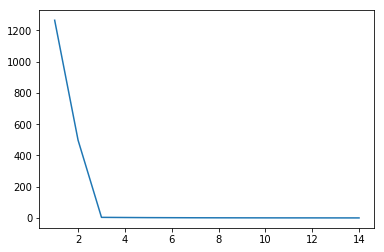

In [23]:
# Running data through model to determine optimal K with all features.
k_clusters = list(range(1, 15))
inertia = []
for k in k_clusters:
    model = KMeans(n_clusters=k)
    model = model.fit(df_final.drop('Category', axis=1))
    inertia.append(model.inertia_)
    
plt.plot(k_clusters, inertia)

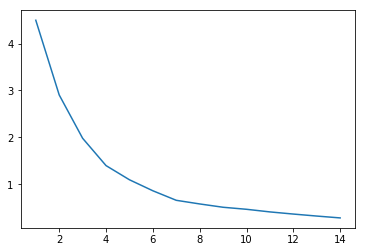

In [24]:
# Running data through model to determine optimal K with only latitude and longitude.
k_clusters = list(range(1, 15))
inertia = []
for k in k_clusters:
    model = KMeans(n_clusters=k)
    model = model.fit(df_final[['Latitude', 'Longitude']])
    inertia.append(model.inertia_)
    
plt.plot(k_clusters, inertia)

In [25]:
# Creating the final clusters.
model = KMeans(n_clusters=7)
model = model.fit(df_final[['Latitude', 'Longitude']])
clustered_group = df_final.copy()
clustered_group.insert(0, 'Cluster Labels', model.labels_)
clustered_group.head()

,Cluster Labels,Latitude,Longitude,Category,Attraction,Food,Service
Venue_Name,,,,,,,
Adhere the 13th Blues Bar,5,13.763043,100.498839,Attraction,1,0,0
Riva Surya Bangkok,5,13.762308,100.493020,Service,0,0,1
Temple of the Emerald Buddha (วัดพระศรีรัตนศาสดาราม (วัดพระแก้ว)),5,13.751735,100.492651,Attraction,1,0,0
Dusit Maha Prasat Throne Hall (พระที่นั่งดุสิตมหาปราสาท),5,13.750105,100.490524,Attraction,1,0,0
Look Chin Sri Yan (ลูกชิ้นศรีย่าน),5,13.784805,100.512836,Food,0,1,0


In [65]:
# Creating map of Thailand.
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

x = np.arange(7)
ys = [i + x + (i*x)**2 for i in range(7)]
colors_array = plt.cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to map
for lat, lng, name, label in zip(clustered_group['Latitude'], clustered_group['Longitude'], clustered_group['Category'], clustered_group['Cluster Labels']):
    folium.CircleMarker(
        location=[lat, lng],
        radius=5,
        color=rainbow[label-1],
        fill=True,
        fill_color=rainbow[label-1],
        fill_opacity=0.7).add_to(map_clusters)  

# add centroids to map
for lat, lang in model.cluster_centers_:
    folium.CircleMarker(
        location=[lat, lang],
        radius=5,
        color='black',
        fill=True,
        fill_color='black',
        fill_opacity=0.7).add_to(map_clusters)  

map_clusters

[13.71820846093777, 100.52075198884063]
[13.73116525284773, 100.57308495715607]
[13.815422008805333, 100.55915363857069]
[13.833787852814021, 100.46888542129045]
[13.748058562329687, 100.54058211790503]
[13.76032674335472, 100.4908838649444]
[13.733192139288361, 100.42171333289963]
